#  Прогнозирование заказов такси


Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.

**Задача:** Пострить модель для прогнозирования количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

**Цель:** Значение метрики RMSE на тестовой выборке должно быть не больше 48.




In [1]:
# ! pip install statsmodels
# ! pip install prophet

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import prophet

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [2]:
# Вспомогательные функции

def plotik(data, name, size=None):
    "Функция отрисовки графиков"
    data.plot(figsize=size)
    plt.title(name)
    plt.ylabel('Среднее количество заказов')
    plt.xlabel('Период');
    return




def make_features(data, max_lag, rolling_mean_size):
    '''Функция для генерации признаков.
    На входе: датасет, максимальное число сдвига и размер кользящего окна'''
    for lag in range(1, max_lag + 1):
        col = f'lag_{lag}'
        data[col] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    data['rolling_std'] = data['num_orders'].shift(1).rolling(rolling_mean_size).std()
    return




def split(data):
    '''Функция разделения датасета на обучающие и тестовые признаки и таргет'''
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train.dropna(inplace=True)
    
    features_train = train.drop('num_orders', axis=1)
    target_train = train['num_orders']
    
    features_test = test.drop('num_orders', axis=1)
    target_test = test['num_orders']
    
    return features_train, features_test, target_train, target_test




def preprocessor(features_train, features_test, col_num=4, marker=1):
    '''Функция для горячего кодирования и стандарного мастштабирования'''
    if marker == 1:
        categorial_col = features_train.columns[:col_num]
        numeric_col = features_test.columns[col_num:]
    else:
        numeric_col = features_test.columns
    
    scaler = StandardScaler()
    scaler.fit(features_train[numeric_col])
    features_train_scal = scaler.transform(features_train[numeric_col])
    features_test_scal = scaler.transform(features_test[numeric_col])
    if marker == 0:
        return features_train_scal, features_test_scal
     
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(features_train[categorial_col])
    features_train_ohe = ohe.transform(features_train[categorial_col])
    features_test_ohe = ohe.transform(features_test[categorial_col])
    
    features_train_total = np.hstack([features_train_ohe, features_train_scal])
    features_test_total = np.hstack([features_test_ohe, features_test_scal])
        
    return features_train_total, features_test_total

Загружаю данные, установив индексом колонку со временем/датой, отсортируя в хронологическом порядке

In [3]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]).sort_index(ascending=True)
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]).sort_index(ascending=False)

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.index.is_monotonic

True

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В колонке `'num_orders'` лежат количество заказов в целоцисленном формате. Всего 26496 строк, пропусков нет. Выполню ресемплирование данных по одному часу. Агрегирование проведу по суммарному значению. 

In [6]:
df = df.resample('1H').sum()

In [7]:
print(f'После агрегирования стало {df.shape[0]} строк')

После агрегирования стало 4416 строк


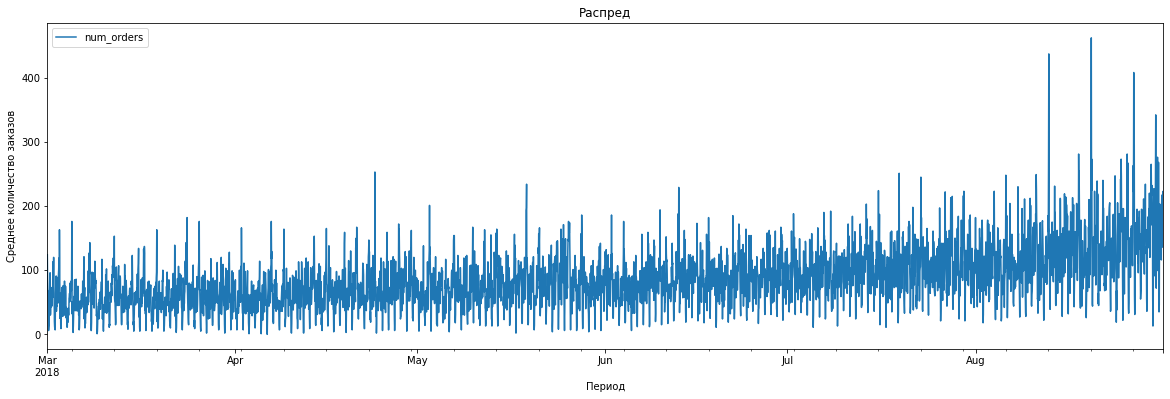

In [8]:
plotik(df, 'Распред', (20, 6))

In [9]:
print(f'Данные с {df.index.min()} по {df.index.max()}')

Данные с 2018-03-01 00:00:00 по 2018-08-31 23:00:00


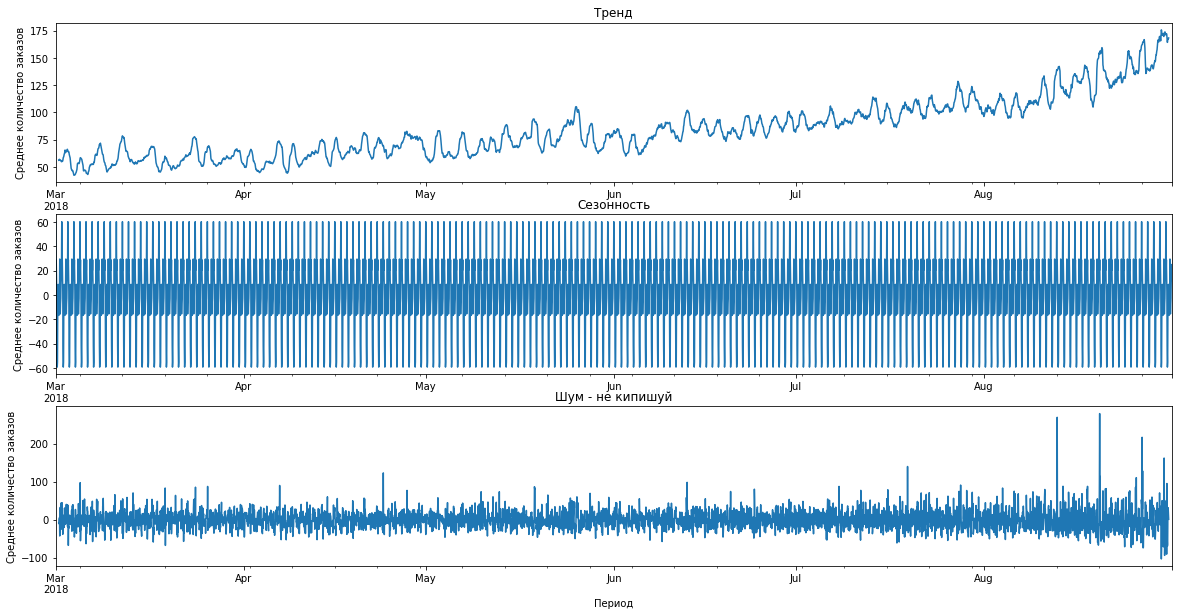

In [10]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plotik(decomposed.trend, 'Тренд')
plt.subplot(3, 1, 2)
plotik(decomposed.seasonal, 'Сезонность')
plt.subplot(3, 1, 3)
plotik(decomposed.resid, 'Шум - не кипишуй')

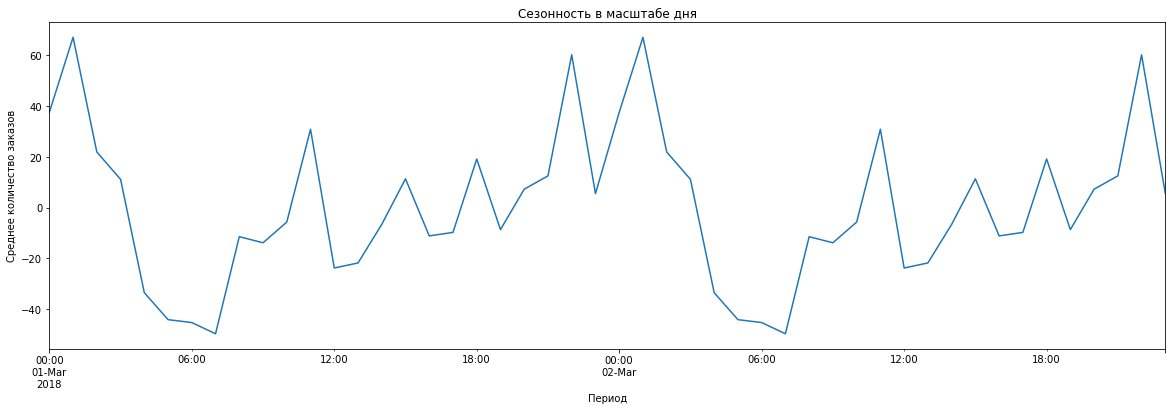

In [11]:
plotik(seasonal_decompose(df['2018-03-01':'2018-03-02']).seasonal, 'Сезонность в масштабе дня', (20, 6))

Разбив данные на три составляющие - тренд, сезонность, шум, - можно заметить, что:
* с марта по конец августа количество заказов в аэропортах увеличивается. Это может быть связано и как с отпусками, так и ч ЧМ по футболу в 2018 году
* меньше всего заказов в период 3:00 - 8:00 (рейсов меньше)
* ближе к августу остаток/шум увеличивается

Проверю ряд на стационарность с помощью теста Дики — Фуллера, который реализован в виде функции `adfuller` модуля `statsmodels`. 
Тест основан на двух гипотезах:
* H0: предполагает, что временной ряд имеет единичный корень, то есть он нестационарный (такси вызывается в случайном порядке).
* H1: предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным. Если эта гипотеза верна, то у нас есть список покупок подарков на определенный временной период, в котором количество подарков для близких коллег и знакомых будет неизменно.

Функция на входе принимает временной ряд, а под индексом [1] возврящает p-value. Уровень значимости приму 0.05.

In [12]:
fuller = adfuller(df)
if fuller[1] < 0.05:
    print('Отвергаем нулевую гипотезу. Единичных корней нет - ряд стационарен')
else:
    print('Принимаем нулевую гипотезу. Есть единичный корень - ряд нестационарен')

Отвергаем нулевую гипотезу. Единичных корней нет - ряд стационарен


Отлично, ряд стационарен. Значит, его можно обучать. Создам признаки:
* Календарные признаки: день, месяц, день недели и час (год не будем, так как данные только за год)
* Отстающее значение 
* Скользящее среднее
* Скользящее стандартное отклонение

In [13]:
# plotik(seasonal_decompose(df).seasonal['2018-07-31':'2018-08-31'], 'Сезонность в масштабе месяца', (20, 6))

In [14]:
ml_data = df.copy()
ml_data['day'] = ml_data.index.day
ml_data['month'] = ml_data.index.month
ml_data['dayofweek'] = ml_data.index.dayofweek
ml_data['hour'] = ml_data.index.hour

## Линейная регрессия

Создам модель линейной регргессии. Изменяемыми гиперпараметрами будут:
* Маскимальный сдвиг отстающего значения `lag features`
* Размер окна скользящего среднего и скользящего стандартного отклонения `rolling_mean`

Для всех переменных сделаем стандартное масштабирование.

Кросс-валидация будет производиться с помощью `TimeSeriesSplit` по RMSE.

In [15]:
def linear_reg(X_tr, y_tr):
    linear = LinearRegression()
    scores = cross_val_score(linear, X_tr, y_tr, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
    score_cv = (-scores.mean())**0.5
#     print('RMSE кросс-валидации:', score_cv)
    return score_cv

In [16]:
rmse_lin = 100
best_lag = 0
best_rol = 0
for i in range(2, 6):
    for j in range(10, 21, 2):
        make_features(ml_data, i, j)
        X_train, X_test, y_train, y_test = split(ml_data)
        X_train, X_test = preprocessor(X_train, X_test, marker=0)
        sc = linear_reg(X_train, y_train)
        if rmse_lin > sc:
            best_lag = i
            best_rol = j
            rmse_lin = sc

print('=================== линейная регрессия ====================')
print('RMSE на кросс-валидации:', rmse_lin)
print('Лучший остающий сдвиг:', best_lag)
print('Лучший размер окна скользящих:', best_rol)

=================== линейная регрессия ====================
RMSE на кросс-валидации: 31.539564525231228
Лучший остающий сдвиг: 3
Лучший размер окна скользящих: 20


## prophet

Обучу модель с помощью библиотеки `prophet`. Данная библиотека требует строгое название колонки с временным рядом - `'ds'`, и целевой переменной - `'y'`, а также не нуждается в генерации признаков, поэтому воспользуюсь исходным датаседом `df`.

In [17]:
ml_prophet = df.reset_index()
ml_prophet.columns = ['ds', 'y']

In [18]:
clf = prophet.Prophet()
train_prophet, test_prophet = train_test_split(ml_prophet, shuffle=False, test_size=0.1)
clf.fit(train_prophet)
feature = clf.make_future_dataframe(periods=test_prophet.shape[0], freq='H')
result = clf.predict(feature)

13:06:26 - cmdstanpy - INFO - Chain [1] start processing
13:06:27 - cmdstanpy - INFO - Chain [1] done processing


Взгляну на признаки, которые сгенерировал prophet

In [19]:
result.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-01 00:00:00,54.468117,58.273917,121.598978,54.468117,54.468117,34.110800,34.110800,34.110800,32.104992,32.104992,32.104992,2.005808,2.005808,2.005808,0.0,0.0,0.0,88.578917
1,2018-03-01 01:00:00,54.474224,56.790151,118.342639,54.474224,54.474224,34.194813,34.194813,34.194813,32.692945,32.692945,32.692945,1.501868,1.501868,1.501868,0.0,0.0,0.0,88.669037
2,2018-03-01 02:00:00,54.480332,52.237280,117.157412,54.480332,54.480332,30.316191,30.316191,30.316191,29.343923,29.343923,29.343923,0.972268,0.972268,0.972268,0.0,0.0,0.0,84.796523
3,2018-03-01 03:00:00,54.486439,38.779302,103.410122,54.486439,54.486439,16.237213,16.237213,16.237213,15.810359,15.810359,15.810359,0.426854,0.426854,0.426854,0.0,0.0,0.0,70.723652
4,2018-03-01 04:00:00,54.492547,12.508476,80.400871,54.492547,54.492547,-9.609882,-9.609882,-9.609882,-9.485558,-9.485558,-9.485558,-0.124325,-0.124325,-0.124325,0.0,0.0,0.0,44.882665


In [20]:
rmse_prophet = mean_squared_error(df['num_orders'].iloc[:train_prophet.shape[0]], 
                                                    result['yhat'].iloc[:train_prophet.shape[0]], squared=False)

print('=================== prophet ====================')
print('RMSE обучающей выборки:', rmse_prophet)

=================== prophet ====================
RMSE обучающей выборки: 24.588666741686964


## Catboost

Попробую обучить модель градиентного бустинга, используя лучшие гиперпараметры модели линейной регрессии. Сделаю также категориалльными переменными все признаки, связанные со временем - кодирую их OHE.

Кросс-валидация и подбор параметров будет происходить с помощью `GridSearchCV` и `TimeSeriesSplit`

In [21]:
def grid_search(model, param, X_tr, y_tr):
    '''Функция подбора гиперпараметров с помощью RandomizedGridSearchCV.
       На входе принимает модель, словарь с гиперпараметрами, фичи и таргет.
       На выходе - словарь с лучшими гиперпараметрами'''
    
    grid = GridSearchCV(model, param, n_jobs=-1, cv=TimeSeriesSplit(n_splits=5), 
                              scoring='neg_mean_squared_error')
    grid.fit(X_tr, y_tr)
    best_score = (-grid.best_score_)**0.5
    print('RMSE кросс-валидации:', best_score)
    return best_score, grid.best_params_

def cat_boost(X_tr, y_tr, X_te, y_te, param):
    '''Функция cat_boost.
       На входе принимает фичи и таргеты обучающей и тестовой выборок.
       На выходе - оценка RMSE, время обучения и время предсказания'''
    print('=============== CatBoost ===============')
    clf = CatBoostRegressor(random_state=42, verbose=False, loss_function='RMSE')
    score_cv, m = grid_search(clf, param, X_tr, y_tr)
    clf = CatBoostRegressor(random_state=42,
                            verbose=False, **m)
    clf.fit(X_tr, y_tr)

    predict = clf.predict(X_te)
    
    return score_cv, clf

In [22]:
ml_data['day'] = ml_data['day'].astype('category')
ml_data['month'] = ml_data['month'].astype('category')
ml_data['dayofweek'] = ml_data['dayofweek'].astype('category')
ml_data['hour'] = ml_data['hour'].astype('category')

make_features(ml_data, best_lag, best_rol)
X_train, X_test, y_train, y_test = split(ml_data)
X_train, X_test = preprocessor(X_train, X_test)

In [23]:
rmse_cat_boost, best_cat_boost = cat_boost(X_train, y_train, X_test, y_test,
                                           {'iterations': range(10, 101, 10),
                                           'depth': range(2, 11),
                                           'learning_rate': np.arange(0, 1.2, 0.2)})

=============== CatBoost ===============
RMSE кросс-валидации: 25.908108462627467


# prophet + CatBoost

Попробую воспользоваться признаками, которые сгенерировал `prophet` в `result`, и обучить на них CatBoost

In [24]:
X_train_combo, X_test_combo = train_test_split(result.loc[:,'trend':'weekly_upper'], shuffle=False, test_size=0.1)
X_train_combo, X_test_combo = preprocessor(X_train_combo, X_test_combo, marker=0)
y_train_combo = df['num_orders'].iloc[:X_train_combo.shape[0]]
y_test_combo = df['num_orders'].iloc[X_train_combo.shape[0]:]

rmse_combo, best_combo = cat_boost(X_train_combo, y_train_combo, X_test_combo, y_test_combo,
                                           {'iterations': range(10, 101, 10),
                                           'depth': range(2, 11),
                                           'learning_rate': np.arange(0, 1.2, 0.2)})

=============== CatBoost ===============
RMSE кросс-валидации: 24.243012068586705


In [25]:
table = pd.DataFrame({'CatBoost' : [rmse_cat_boost], 
                      'prophet' : [rmse_prophet],
                      'линейная регрессия' : [rmse_lin],
                      'prophet + CatBoost' : [rmse_combo]},
                      index=['RMSE_cv']).T
table

,RMSE_cv
CatBoost,25.908108
prophet,24.588667
линейная регрессия,31.539565
prophet + CatBoost,24.243012


Комбинация prophet с CatBoost дает самую низкую оценку кросс-валидации. Однако, чистый prophet дает почти такую же оценку, но обучется заметно быстрее. Немного выше чистый CatBoost. На последнем месте обычная линейная регрессия. 

Построю прогноз при модели prophet - метрика такая же, как и у prophet+CatBoost, но гораздо быстрее.

In [26]:
print('RMSE прогноза',
mean_squared_error(df['num_orders'].iloc[-test_prophet.shape[0]:], 
                    result['yhat'].iloc[-test_prophet.shape[0]:], squared=False)
)

RMSE прогноза 48.24537848064678


Опа, оценка прогноза выше предельной RMSE=45. Что же покажет prophet+CatBoost?

In [27]:
print('RMSE прогноза',
mean_squared_error(y_test_combo, best_combo.predict(X_test_combo), squared=False)
     )

RMSE прогноза 43.67005413767226


Проверю качество прогнозирования способом, когда новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1)

In [28]:
pred_previous = test_prophet['y'].shift(1, fill_value=test_prophet['y'].iloc[-1])

print("RMSE:", mean_squared_error(test_prophet['y'], pred_previous, squared=False))

RMSE: 59.054503546641314


Прогноз ниже дефолного. То есть наша модель лучше работоспособна.

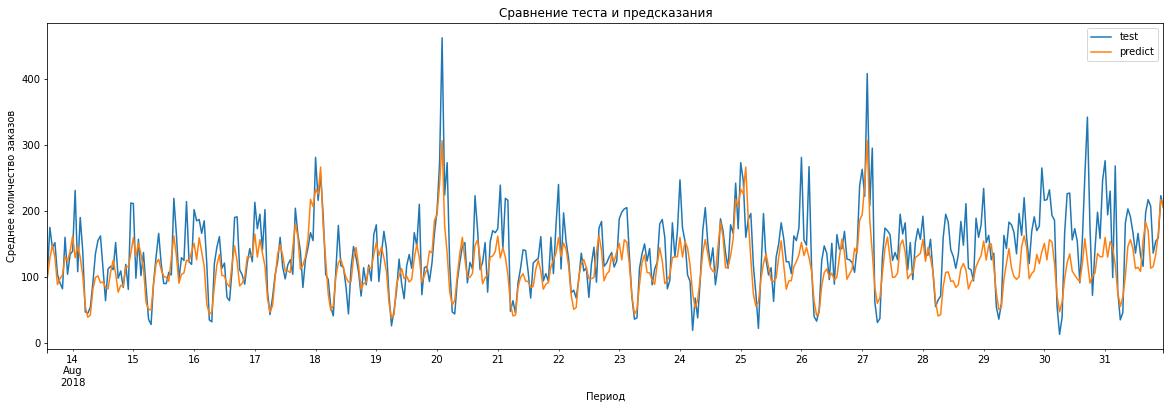

In [29]:
plotik(pd.DataFrame({'test' : y_test_combo,
              'predict' : best_combo.predict(X_test_combo)},
             index=y_test_combo.index), 'Сравнение теста и предсказания', (20, 6))

# Вывод

Построил несколко моделей для прогнозирования количества заказов такси у аэропортов на следующий час:
* линейная регрессия
* Facebook Prophet
* CatBoost
* Prophet + CatBoost

Выяснил, что комбинированная модель Prophet + CatBoost (входные признаки для CatBoost получены с помощью Prophet) дает лучшую оценку кросс-валидации. Такая модель несколько лучше чистого Prophet. Однако скорость такого обучения на несколько порядков ниже. Поэтому возник соблазн применять только Prophet. Однако оценка предсказания чистого Prophet дала значение выше заданного заказчиком.